# Modelling and prediction of a CVD process
1. Use regression model to predict thickness for every single site
2. Adapt model to also consider X and Y coordinates of the site to form a single model

## TODO
- Integrate temperature via scaling of predicted output values
- Optional: Hyperparameter tuning for ANN, improve stability of model quality, show learning rate
- Optional: Encode TOOL into dummy variables instead of scalar
- Optional: encode X, Y coordinates into dummy variables / allow for prediction based on any X and Y coordinates, not only fixed sites

## 1. Preprocessing
### Import data
- Import raw data from csv files
- Set all independant variables as X as array
- Set dependant variable Layer thickness as y

### Split data & Feature scaling
- Split into training and test data (75:25)
- Fix seed for randomness
- Scale all features using StandardScaler

### Inlcude temperature
- Thickness factors from literature:
  - 500 °C = 0.94
  - 480 °C = 1.0 (*default*)
  - 460 °C = 1.04

In [181]:
import pandas as pd
import numpy as np
from tkinter import *
from tkinter.ttk import Combobox
from matplotlib.figure import Figure
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from numpy.random import seed
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import RMSprop
from tensorflow import random

%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [10, 8]

seed(0)
random.set_seed(0)

DIR = './'
SITES = 'site_coordinates.csv'
DATA = 'test_assignment_sim.csv'

raw_sites = pd.read_csv(DIR+SITES)
raw_data = pd.read_csv(DIR+DATA)

X = raw_data.iloc[:,0:53]
y = raw_data.iloc[:,4:53]

# Add Temperature as feature in X
# Scale final prediction based on temperature
X['Temperature'] = 480
#X_500 = X.copy()
#X_500['Temperature'] = 500
#X_460 = X.copy()
#X_460['Temperature'] = 460

# Adjust Thickness in y for 460 and 500 °C
#y_500 = y.copy()
#y_500 = y_500  *0.94
#y_460 = y.copy()
#y_460 = y_460 * 1.04
#y = y.append(y_500, ignore_index=True).append(y_460, ignore_index=True)

# Adjust Thickness in X for 460 and 500 °C
#X_500.iloc[:, 4:-1] = X_500.iloc[:, 4:-1] * 0.94
#X_460.iloc[:, 4:-1] = X_460.iloc[:, 4:-1] * 1.04
#X = X.append(X_500, ignore_index=True).append(X_460, ignore_index=True)

# Select only process parameters as independent variables
X = X.iloc[:, [0,1,2,3, -1]]

def preprocess(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)
    sc_X = StandardScaler()
    X_train = sc_X.fit_transform(X_train)
    X_test = sc_X.transform(X_test)
    sc_y = StandardScaler()
    y_train = sc_y.fit_transform(y_train)
    return X_train, X_test, y_train, y_test, sc_X, sc_y

## 2. Train model

In [3]:
# 5 input nodes
# 2 layers of 27 nodes
# 49 output nodes
# r^2 score = 0.974 +/- 0.1?

X_train, X_test, y_train, y_test, sc_X, sc_y = preprocess(X, y)
regressor = Sequential()
regressor.add(Dense(units=27, activation='relu', input_dim=X_train.shape[1]))
regressor.add(Dense(units=27, activation='relu'))
regressor.add(Dense(units=49))
regressor.compile(optimizer=RMSprop(0.001), loss='mse', metrics=['mae','mse'])
regressor.fit(X_train, y_train, batch_size=10, epochs=100, verbose=0)
y_pred = sc_y.inverse_transform(regressor.predict(X_test))
r2_ann_multi = r2_score(y_test, y_pred)
print('r^2 score: ', r2_ann_multi);

r^2 score:  0.9731737670846602


## 3. Predictions
**Input process parameters to get a prediction of layer thickness on all wafer sites:**

In [ ]:
def predict():
#def predict(flow = 0.92, spacing = 0.35, deptime = 70, tool = 2, temperature = 480):
    flow = in_flow.get()
    spacing = in_spacing.get()
    deptime = in_deptime.get()
    temperature = in_temperature.get()
    tool = cb_tool.get()
    
    parameters = np.array([flow, spacing, deptime, tool, temperature]).reshape(1,-1)
    parameters = sc_X.transform(parameters)
    print('Process parameters:\nFLOWFACTOR:\t{}\nSPACING:\t{}\nDEP TIME:\t{} s\nTOOL:\t\t#{}\nTemperature:\t{} °C\n'.format(
    flow, spacing, deptime, tool, temperature))
    y_pred = sc_y.inverse_transform(regressor.predict(parameters))
    print('Predicted SiO2 layer thickness for all sites (1 - 49):\n\n', y_pred);
    
    lbl_result = Label(window, text="Thickness prediction: ", font=("Helvetica", 11))
    lbl_result.place(x=pos_x_labels, y=y_tool+70)
    result_box = Listbox(window, height=20)
    for _ in range(0, len(y_pred[0])):
        entry = 'Site ' + str(_) + ': ' + str(y_pred[0][_])
        result_box.insert(_+1, entry)
    result_box.place(x=pos_x_labels+3, y=y_tool+95)
    
    df_pred = pd.DataFrame()
    df_pred['Prediction'] = y_pred.flatten()
    df_pred['X'] = raw_sites.SITE_X.values.round(0)
    df_pred['Y'] = raw_sites.SITE_Y.values.round(0)
    fig, ax1 = plt.subplots()
    fig = Figure(figsize = (9, 6), facecolor = "white")
    ax1.set_title('Predicted SiO2 layer thickness')

    df_pred.plot.scatter('X', 'Y', c='Prediction', colormap='Blues', ax=ax1)
    # siehe http://blog.schockwellenreiter.de/2017/07/2017071803.html
    canvas = FigureCanvasTkAgg(fig, master = window)
    #canvas._tkcanvas.pack(side = tkinter.TOP, fill = tkinter.BOTH, expand = 1)
    return y_pred

Process parameters:
FLOWFACTOR:	0.93
SPACING:	0.35
DEP TIME:	68 s
TOOL:		#3
Temperature:	480 °C

Predicted SiO2 layer thickness for all sites (1 - 49):

 [[1433.9572 1405.0398 1439.2379 1434.7142 1434.0214 1430.4054 1442.7784
  1442.3138 1438.661  1471.2316 1468.5676 1470.1423 1467.7303 1465.9049
  1463.8109 1460.9425 1459.0864 1456.3063 1472.4149 1471.9606 1471.1064
  1469.7777 1471.5793 1473.3794 1473.0735 1410.4941 1415.3949 1410.6349
  1409.065  1408.7882 1409.6793 1408.3336 1405.0165 1404.1371 1403.0916
  1401.7291 1401.7874 1400.0181 1412.0922 1414.2323 1412.8362 1416.909
  1417.8838 1413.2594 1414.2982 1412.7036 1413.4751 1412.6177 1413.6653]]


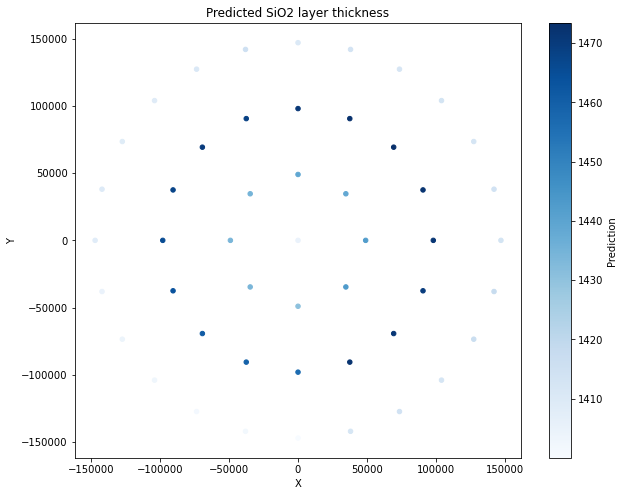

In [190]:
window = Tk()
width = 450
height = 600
pos_x = '+0' # Specify +/- for position from left or right side
pos_y = '+0' # Specify +/- for position from left or right side
window.title('CVD process predicter')
window.geometry('{}x{}{}{}'.format(width, height, pos_x, pos_y))
#window.config()

lbl_intro = Label(window, text="Define process parameters", font=("Helvetica", 10))
lbl_intro.place(x=5, y=5)

pos_x_labels = 5
pos_y_labels = 35
pos_x_in = pos_x_labels + 150

lbl_flow = Label(window, text="Flow factor: ", font=("Helvetica", 11))
lbl_flow.place(x=pos_x_labels, y=pos_y_labels)
in_flow = Entry(window, bd=1)
in_flow.insert(0, '0.93')
in_flow.place(x=pos_x_in, y=pos_y_labels+2)

lbl_spacing = Label(window, text="Spacing: ", font=("Helvetica", 11))
lbl_spacing.place(x=pos_x_labels, y=pos_y_labels+5*6)
in_spacing = Entry(window, bd=1)
in_spacing.insert(0, '0.35')
in_spacing.place(x=pos_x_in, y=pos_y_labels+5*6+2)

lbl_deptime = Label(window, text="Deposition time [s]: ", font=("Helvetica", 11))
lbl_deptime.place(x=pos_x_labels, y=pos_y_labels+5*11)
in_deptime = Entry(window, bd=1)
in_deptime.insert(0, '68')
in_deptime.place(x=pos_x_in, y=pos_y_labels+5*11+2)

lbl_temperature = Label(window, text="Temperature [°C]: ", font=("Helvetica", 11))
lbl_temperature.place(x=pos_x_labels, y=pos_y_labels+5*16)
in_temperature = Entry(window, bd=1)
in_temperature.insert(0, '480')
in_temperature.place(x=pos_x_in, y=pos_y_labels+5*16+2)

y_tool = pos_y_labels+5*21
lbl_tool = Label(window, text="Tool: ", font=("Helvetica", 11))
lbl_tool.place(x=pos_x_labels, y=y_tool)
cb_tool = Combobox(window, values=['1', '2', '3', '4'])
cb_tool.place(x=pos_x_in, y=y_tool)
cb_tool.current(0)


btn = Button(window, text="Calculate", fg='blue', command=predict)
btn.place(x=pos_x_labels, y=y_tool+35)

window.mainloop();